In [1]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import skimage

In [319]:
im_dir = "samples/duck.jpg"
img = cv2.imread(im_dir)
img = img.astype(np.float32)/255
channels = img.shape[-1]

In [325]:
def display_img(img):
    img_rgb = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2RGB)
    img_rgb = np.clip(img_rgb,a_min=0,a_max=1)
    plt.imshow(img_rgb)

In [340]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

<h1>Base Image</h1>

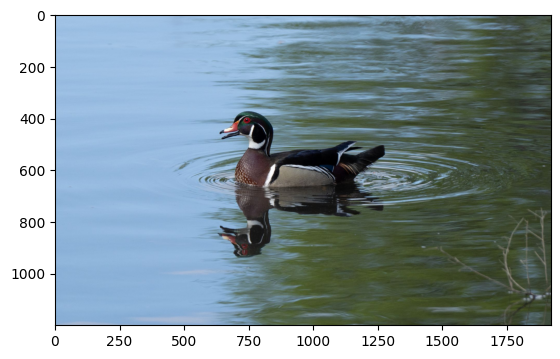

In [366]:
display_img(img)

<h1>Noisy Image</h1>

In [394]:
mu = 0
sigma = 0.4
noise = np.random.normal(mu, sigma, size=img.shape)
img_noisy = img + noise

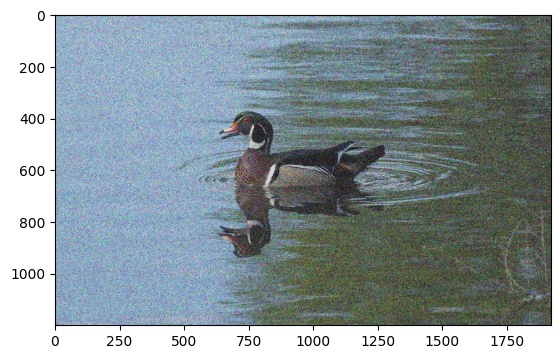

In [395]:
display_img(img_noisy)

<h1>Noisy Image Denoised</h1>

In [396]:
img_denoised = skimage.restoration.denoise_wavelet(img_noisy, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft', rescale_sigma=True)

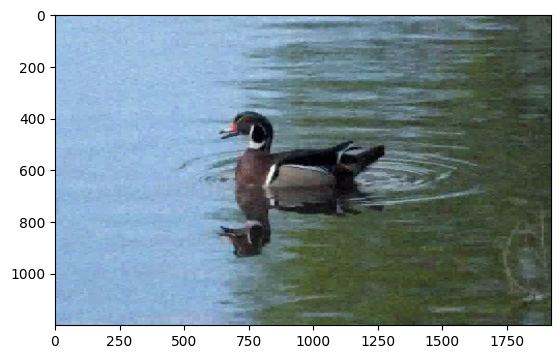

In [397]:
display_img(img_denoised)

<h1>Blurred Image</h1>

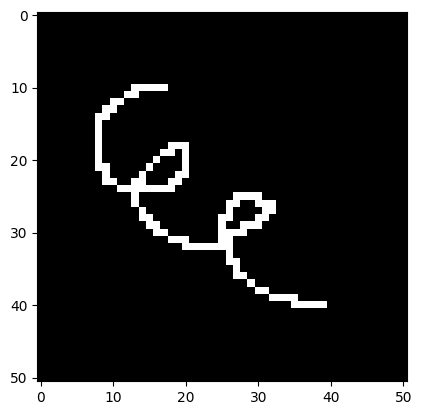

In [8]:
kernel_dir = "kernels/kernel_51x51.png"
kernel = cv2.imread(kernel_dir, cv2.IMREAD_GRAYSCALE)
kernel = kernel.astype(np.float32)/255
kernel = kernel/np.sum(kernel)
plt.imshow(kernel, cmap='gray')

In [ ]:
img_blurry = np.stack([scipy.ndimage.convolve(img[:,:,i], kernel, mode='mirror') for i in range(channels)],axis=2)

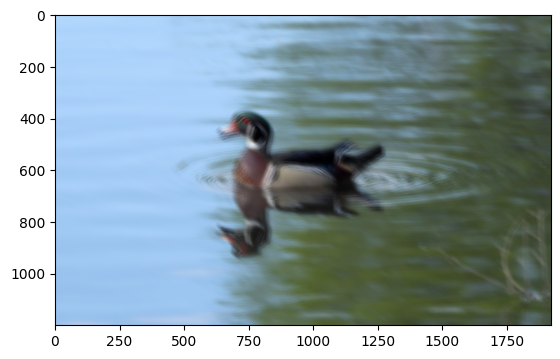

In [331]:
display_img(img_blurry)

<h1>Kernel Estimation</h1>

In [12]:
b = img_blurry[200:1000, 500:1300 ,0].flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[200:1000,500:1300,0]
I_pad = img_denoised[175:1025,475:1325,0]
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(850, 850)
(640000, 2601)


In [13]:
for i in range(800):
    for j in range(800):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

<h2>Least Squares Method</h2>

In [ ]:
k_rec_lstsq = np.linalg.lstsq(A,b)

In [14]:
print(k_rec_lstsq[0].shape)
k_rec_lstsq_processed = k_rec_lstsq[0].copy()
k_rec_lstsq_processed[k_rec_lstsq_processed<0] = 0
plt.imshow(k_rec_lstsq_processed.reshape((51,51)), cmap='gray')

NameError: name 'k_rec_lstsq' is not defined

<h2>Landweber Method</h2>

In [14]:
b = img_blurry[200:1000, 500:1300 ,0].flatten()
A = np.zeros((b.shape[0], (51*51)))
I = img_denoised[200:1000,500:1300,0]
I_pad = img[175:1025,475:1325,0]
#I_pad = np.pad(I, ((25,25),(25,25)))
print(I_pad.shape)
print(A.shape)

(850, 850)
(640000, 2601)


In [15]:
for i in range(800):
    for j in range(800):
        conv_area = I_pad[i:i+51, j:j+51]
        A[i*I.shape[1]+j] = conv_area.flatten()

In [18]:
a = np.isnan(A)
print(a[a==True])

[]


In [33]:
def landweber(A, b, beta=1.0, lamb=5.0):
    k = np.zeros(A.shape[1])
    k[0] = 1.0 # apply delta function
    print("Calculating ATb")
    ATb = A.T@b
    print("Calculating ATA with lambda")
    ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
    print("Running iterative loop")
    for i in range(100):
        tmp = ATA_lambda@k
        # if i%10==0:
        #     print(ATb, tmp)
        k_next = k + beta * (ATb - tmp)
        k_next[k_next < 0] = 0
        k_sum = np.sum(k_next)
        # if (k_sum <= 0):
        #     k_next = np.zeros(A.shape[1])
        #     k_next[0] = 1.0
        # else:
        if k_sum > 0:
            k_next = k_next / k_sum
        convergence = np.linalg.norm(k_next - k)
        k = k_next.copy()
        if ((i%10)==0):
            print(convergence)
    return k

In [36]:
k_rec_landweber = landweber(A,b,lamb=0.0)

Calculating ATb


/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:5: RuntimeWarning: divide by zero encountered in matmul
  ATb = A.T@b
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:5: RuntimeWarning: overflow encountered in matmul
  ATb = A.T@b
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:5: RuntimeWarning: invalid value encountered in matmul
  ATb = A.T@b


Calculating ATA with lambda


/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:7: RuntimeWarning: divide by zero encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:7: RuntimeWarning: overflow encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:7: RuntimeWarning: invalid value encountered in matmul
  ATA_lambda = A.T@A + lamb**2 * np.eye(A.shape[1])
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:10: RuntimeWarning: divide by zero encountered in matmul
  tmp = ATA_lambda@k
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:10: RuntimeWarning: overflow encountered in matmul
  tmp = ATA_lambda@k
/var/folders/22/y_dwlpm545lc1b2_nc6r3t9w0000gp/T/ipykernel_41899/2949641106.py:10: RuntimeWarning: invalid value encountered in matmul
  t

Running iterative loop
1.0638399665866338
0.05167738715248643
0.052043401339057896
0.052131445040377644
0.05214943313524527
0.05215263287114084
0.052153330606887656
0.05215348347340405
0.0521535168038575
0.052153524063473386


(2601,)


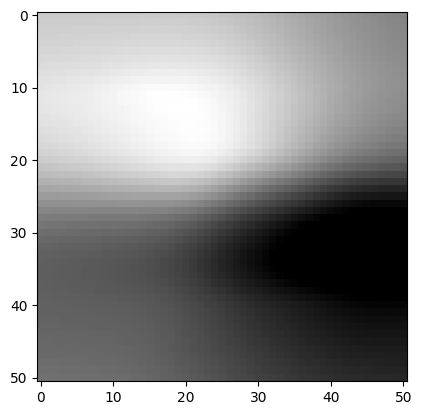

In [37]:
print(k_rec_landweber.shape)
plt.imshow(k_rec_landweber.reshape((51,51)), cmap='gray')

## Residual Deconvolution

In [372]:
def rl_deconvolve(delta_b, K, I_0, num_iters=40):
    I = I_0
    for n in range(num_iters):
        den = np.stack([scipy.ndimage.convolve(I[:,:,i]+1,K, mode='mirror') for i in range(channels)],axis=2)
        tmp = np.stack([scipy.ndimage.correlate((delta_b[:,:,i]+1) / den[:,:,i], K, mode='mirror') for i in range(channels)],axis=2)
        I = tmp * (I+1) - 1

    return I

In [404]:
img_denoised_blurry = np.stack([scipy.ndimage.convolve(img_denoised[:,:,i], kernel, mode='mirror') for i in range(channels)],axis=2)

img_denoised_blurry = normalize(img_denoised_blurry)
img_blurry = normalize(img_blurry)

img_blurry_res = img_blurry - img_denoised_blurry

In [399]:
img_res = rl_deconvolve(img_blurry_res,kernel,img_denoised)

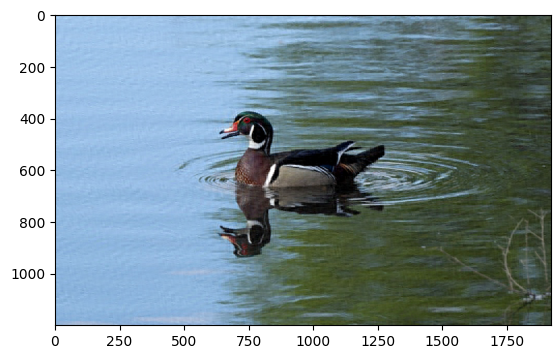

In [400]:
img_recovered = img_denoised + img_res
display_img(img_recovered)

## Gain-controlled RL

In [352]:
def generate_gain_map(Nd, alpha=0.08):
    gaussian_pyramid = tuple(skimage.transform.pyramid_gaussian(skimage.color.rgb2gray(Nd[:,:,[2,1,0]]), max_layer=-1, sigma=0.5))
    grad_sum = 0
    for l in range(len(gaussian_pyramid)):
        gh = skimage.filters.sobel_h(gaussian_pyramid[l])
        gv = skimage.filters.sobel_v(gaussian_pyramid[l])
        grad = np.sqrt(gh**2+gv**2)
        if l > 0:
            grad = cv2.resize(grad, (gaussian_pyramid[0].shape[1], gaussian_pyramid[0].shape[0]))
        
        grad_sum += grad

    I_gain = (1-alpha) + alpha * grad_sum
    I_gain = (I_gain-I_gain.min()) / (I_gain.max()-I_gain.min())

    return I_gain

In [343]:
def gain_controlled_rl(delta_B, K, I_0, I_gain, num_iters=40):
    I = I_0

    for n in range(num_iters):
        den = np.stack([scipy.ndimage.convolve(I[:,:,i]+1,K, mode='mirror') for i in range(channels)],axis=2)
        tmp = np.stack([scipy.ndimage.correlate((delta_B[:,:,i]+1) / den[:,:,i], K, mode='mirror') for i in range(channels)],axis=2)
        I = I_gain[:,:,None] * (tmp * (I+1) - 1)
    
    return I

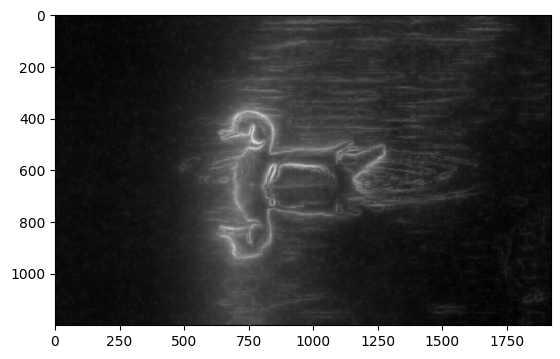

In [405]:
I_gain = generate_gain_map(img_denoised)
plt.imshow(I_gain,cmap='gray')

In [ ]:
img_res_gain_controlled = gain_controlled_rl(img_blurry_res, kernel, img_denoised, I_gain, num_iters=400)

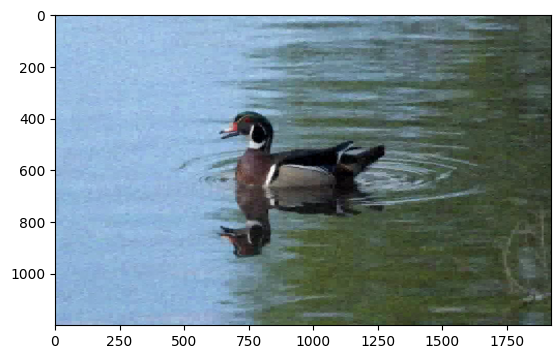

In [ ]:
img_recovered_gain_controlled = img_denoised + img_res_gain_controlled
display_img(img_recovered_gain_controlled)